# This Python notebook provides a comprehensive set of functions for preprocessing data for object detection tasks, with a focus on preparing data for YOLO (You Only Look Once) models through several key steps:

0. Collect the data from the messy folders 

1. Specify Image and Label Paths: Load image and label paths into a DataFrame, facilitating efficient data manipulation.

2. Create Output Folder and Filter Images: Identify and save images with missing annotations to an output folder. Remove these images from the original DataFrame.

3. Preprocess DataFrame for Model Input: Encode class labels, scale width and height, and drop unnecessary columns to create a model-ready DataFrame.

4. Compute Aggregated Metrics: Calculate aggregated metrics, such as average width, average height, and average aspect ratio, to gain insights into the dataset.

5. Assign Fold Numbers with Stratified K-Fold: Implement Multilabel Stratified K-Fold cross-validation to assign fold numbers for training, testing, and validation.

6. Split Data into Train, Test, and Validation Sets: Divide the dataset into train, test, and validation sets based on the assigned fold numbers.

7. Plot Class Distribution: Visualize class distribution across splits to ensure a balanced dataset.

8. Move Images to Respective Folders: Organize images into YOLO-compatible folder structures for each split.

## Resources

General blog:
https://jaidevd.com/posts/obj-detection-stratification/

paper:
https://www.researchgate.net/publication/373451272_Improving_the_performance_of_object_detection_by_preserving_label_distribution

implementation:
https://github.com/leeheewon-01/YOLOstratifiedKFold/tree/main

In [1]:
import os
import yaml
import ruamel.yaml
import pandas as pd
from tqdm import tqdm
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import shutil
import matplotlib.pyplot as plt
import numpy as np
import re

## Collect the data from the messy folders 

In [2]:
def is_image_file(file_path):
    image_extensions = ['.jpg', '.jpeg', '.png', '.svg']  # Add more if needed
    return any(file_path.lower().endswith(ext) for ext in image_extensions)




def create_dataframe_and_folders(input_folder_path, output_folder_path='Collected_data/dataset'):
    """
    Create a DataFrame from image and text files within a given folder and create output folders.

    Parameters:
    - input_folder_path (str): Path to the folder containing images and corresponding text files.
    - output_folder_path (str): Path to the destination folder for the DataFrame and output folders.

    Returns:
    - pd.DataFrame: DataFrame with columns 'image_path' and 'label_path'.
    """
    columns = ['image_path', 'label_path']
    df = pd.DataFrame(columns=columns)
    images_names_dict, labels_dict = {}, {}
    images_names_dict, labels_names_dict = {}, {}

    for root, dirs, files in tqdm(os.walk(input_folder_path), desc="go through the input folder "):

        for file in files:
            if is_image_file(file):
                image_path = os.path.join(root, file)
                filename = os.path.splitext(os.path.basename(image_path))[0]
                file_id = int(re.search(r'\d+', filename).group())
                images_names_dict[image_path] = {'file_id': file_id, 'filename': filename}
                # images_dict[file_id] = image_path
            elif file.endswith('.txt'):
                label_path = os.path.join(root, file)
                filename = os.path.splitext(os.path.basename(label_path))[0]
                file_id = int(re.search(r'\d+', filename).group())
                labels_names_dict[label_path] = {'file_id': file_id, 'filename': filename}
                # labels_dict[file_id] = label_path

    # Check if either file_id or filename matches in both images_names_dict and labels_names_dict
    for image_path, image_info in tqdm(images_names_dict.items(), total=len(images_names_dict), desc="Check if either file_id or filename matches in both images_names_dict and labels_names_dict"):
        for label_path, label_info in labels_names_dict.items():
            if image_info['file_id'] == label_info['file_id'] or image_info['filename'] == label_info['filename']:
                df = pd.concat([df, pd.DataFrame([{'image_path': image_path, 'image_extention': os.path.splitext(image_path)[-1],'label_path': label_path}])], ignore_index=True)
    return df

In [ ]:
df = create_dataframe_and_folders('Collected_data', output_folder_path='Collected_data/dataset')

In [4]:
def count_images(folder_path):
    image_files = [file for file in os.listdir(folder_path) if is_image_file(file)]
    return len(image_files)

In [5]:
def copy_files_to_folders(df, output_folder_path='Collected_data/dataset', mode= 'append'):
    """
    Copy images and text files from source folders to respective output folders based on DataFrame.

    Parameters:
    - df (pd.DataFrame): DataFrame with columns 'image_path' and 'label_path'.
    - output_folder_path (str): Path to the source folder containing images and labels subfolders.

    Returns:
    - None
    """
    # Create output folders if they don't exist
    image_source_path = os.path.join(output_folder_path, 'images')
    text_source_path = os.path.join(output_folder_path, 'labels')

    os.makedirs(image_source_path, exist_ok=True)
    os.makedirs(text_source_path, exist_ok=True)

    if mode == 'append':
        len_files_inside = count_images(image_source_path)
    if mode == 'overwrite':
        len_files_inside = 0
        
    # Iterate through DataFrame and copy files
    for index, row in df.iterrows():
        # Rename files as "image_i" and "text_i"
        image_destination_path = os.path.join(image_source_path, f"image_{len_files_inside}{row['image_extention']}")
        text_destination_path = os.path.join(text_source_path, f"image_{len_files_inside}.txt")

        df.at[index, 'filename'] = os.path.splitext(os.path.basename(image_destination_path))[0]
        df.at[index, 'new_image_path'] = image_destination_path
        df.at[index, 'new_label_path'] = text_destination_path
        len_files_inside += 1

        # Copy image
        shutil.copy(row['image_path'], image_destination_path)
        # Copy text file
        shutil.copy(row['label_path'], text_destination_path)



    if df.shape[1] > 0:
        print("Images and text files copied successfully.")

    return df


## Reads label information from text files associated with images and generates a DataFrame.

In [31]:
def read_txt_from_df(df, task='det'):
    """
    Reads label information from text files associated with images and adds new columns to the DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame containing 'image_path' and 'label_path' columns.
        task (str, optional): Task type, either 'det' for detection or 'seg' for segmentation.
                              Default is 'det'.

    Returns:
        pd.DataFrame: DataFrame with added columns containing information extracted from label files.
                      Columns: ['image_path', 'label_path', 'filename', 'class', 'x', 'y', 'w', 'h'].

    Note:
        For detection task ('det'), each row corresponds to an object in an image.
        For segmentation task ('seg'), each row corresponds to a bounding box around a segmented object.

    Example:
        df = read_txt_from_df(df, task='det')
    """
    # Initialize new columns
    new_columns = ['class', 'x', 'y', 'w', 'h']
    if any(col not in df.columns for col in new_columns):
        for col in new_columns:
            df[col] = None

    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Reading label files"):
        # Check if corresponding text file exists
        if os.path.exists(row['label_path']):
            # If text file exists, read its content
            with open(row['label_path'], 'r') as f:
                lines = f.readlines()

                # Check if the file is empty
                if lines:
                    # Process each line in the text file
                    for line in lines:
                        line = line.split()

                        # Check if the line has the expected number of elements
                        if len(line) == 5:
                            if task == 'seg':
                                # Extract segmentation information
                                x_list = [float(line[i]) for i in range(1, len(line), 2)]
                                y_list = [float(line[i]) for i in range(2, len(line), 2)]
                                x_max, x_min, y_max, y_min = max(x_list), min(x_list), max(y_list), min(y_list)
                                x_center, y_center, w, h = (x_max + x_min) / 2, (y_max + y_min) / 2, x_max - x_min, y_max - y_min
                                #assign info into the df
                                df.at[index, 'class'], df.at[index, 'x'], df.at[index, 'y'] = line[0], x_center, y_center
                                df.at[index, 'w'], df.at[index, 'h']  = w, h

                            elif task == 'det':
                                # Extract detection information
                                df.at[index, 'class'], df.at[index, 'x'], df.at[index, 'y'] = line[0], line[1], line[2]
                                df.at[index, 'w'], df.at[index, 'h'] = line[3], line[4]

                # in case of empty file
                else:
                    # Extract detection information
                    df.at[index, 'class'], df.at[index, 'x'], df.at[index, 'y'] = '-1', None, None
                    df.at[index, 'w'], df.at[index, 'h'] = None, None

        # in case of corresponding text file not exists
        else:
            # Extract detection information
            df.at[index, 'class'], df.at[index, 'x'], df.at[index, 'y'] = '-1', None, None
            df.at[index, 'w'], df.at[index, 'h'] = None, None


    return df

## Get and Drop missed annotated images 

In [7]:
# Function to create an output folder if it doesn't exist and filter images with missed annotations
def get_missed_annot(df, output_folder='missed_annot'):
    """
    Creates an output folder and filters rows with missed annotations.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing annotation information.
        output_folder (str): Output folder path. Default is 'missed_annot'.

    Returns:
        pd.DataFrame: DataFrame containing rows with missed annotations.

    Example:
        missed_annot_df = get_missed_annot(df, output_folder='missed_annot')
    """
    os.makedirs(output_folder, exist_ok=True)

    # Filter rows where class is equal to '-1' indicating missed annotations
    missed_annot_df = df[df['class'] == '-1']

    print("Got", missed_annot_df.shape[0], "images with missed annotations")
    return missed_annot_df

In [46]:
# Function to save images with missed annotations to a specified output folder
def save_missed_annot(missed_annot_df, output_folder='missed_annot'):
    """
    Saves images with missed annotations to a specified output folder.

    Parameters:
        missed_annot_df (pd.DataFrame): DataFrame containing rows with missed annotations.
        output_folder (str): Output folder path. Default is 'missed_annot'.

    Example:
        save_missed_annot(missed_annot_df, input_path='Collected_data/dataset', output_folder='missed_annot')
    """
    os.makedirs(output_folder, exist_ok=True)
    # Save images with missed annotations to the specified output folder
    for index, row in missed_annot_df.iterrows():
        filename = os.path.basename(row['image_path'])
        source_path = row['image_path'] 
        destination_path = os.path.join(output_folder, filename)
        shutil.copyfile(source_path, destination_path)

    print("Images with missed annotations have been copied successfully to", output_folder)

In [9]:
# Function to drop rows with missed annotations from the original DataFrame
def drop_missed_annot(df, missed_annot_df):
    """
    Drops rows with missed annotations from the original DataFrame.

    Parameters:
        df (pd.DataFrame): Original DataFrame containing annotation information.
        missed_annot_df (pd.DataFrame): DataFrame containing rows with missed annotations.

    Example:
        drop_missed_annot(df, missed_annot_df)
    """
    # Drop rows with missed annotations from the original DataFrame
    df.drop(missed_annot_df.index, inplace=True)

    print(missed_annot_df.shape[0], "images with missed annotations from the original DataFrame have been dropped successfully!")


## one-hot encoding the classes 

In [10]:
# Function to Preprocesses the input DataFrame by one-hot encoding 'class', scaling 'w' and 'h' by 1000, dropping unnecessary columns
def process_dataframe(df):
    """
    Preprocesses the input DataFrame by one-hot encoding 'class', scaling 'w' and 'h' by 1000,
    dropping unnecessary columns, and grouping by 'filename'.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing annotation information.

    Returns:
        pd.DataFrame: Processed DataFrame with one-hot encoded 'class', scaled 'w' and 'h', and grouped by 'filename'.

    Example:
        processed_df = process_dataframe(df)
    """
    processed_df = (
        pd.get_dummies(df, columns=['class'], prefix='class')  # One-hot encode 'class' column
        .assign(w=lambda df: df['w'].astype(float) * 1000, h=lambda df: df['h'].astype(float) * 1000)  # Scale 'w' and 'h' by 1000
        .drop(['x', 'y'], axis=1)  # Drop unnecessary columns 'x' and 'y'
        .groupby('filename', as_index=False)  # Group by 'filename'
        .sum()  # Sum the grouped values
    )
    return processed_df

## compute aggregated metrics

In [11]:
def compute_aggregated_metrics(df):
    """
    Computes aggregated metrics including 'cnt', 'avg_w', 'avg_h', and 'avg_ratio'
    from the input DataFrame.

    Parameters:
        df (pd.DataFrame): Input DataFrame containing processed annotation information.

    Returns:
        pd.DataFrame: DataFrame with computed aggregated metrics.

    Example:
        aggregated_df = compute_aggregated_metrics(df)
    """
    aggregated_df = (
        df.assign(
            cnt=lambda df: df.filter(regex='^class_').sum(axis=1).clip(lower=1),  # Compute 'cnt' as the sum of one-hot encoded class columns, with a lower limit of 1
            avg_w=lambda df: df['w'] / df['cnt'],  # Compute 'avg_w' as the ratio of 'w' to 'cnt'
            avg_h=lambda df: df['h'] / df['cnt'],  # Compute 'avg_h' as the ratio of 'h' to 'cnt'
            avg_ratio=lambda df: df['w'] / df['h'].replace(0, 1)  # Compute 'avg_ratio' as the ratio of 'w' to 'h', replacing 0 with 1 to avoid division by zero
        )
        .drop(['w', 'h'], axis=1)  # Drop the original 'w' and 'h' columns
    )

    return aggregated_df

## Split the data: 
- stratifiedKFold
- train, val, and test split

In [12]:

def assign_stratifiedKFold(df, n_splits=10, shuffle=True, random_state=42):
    """
    Assigns fold numbers to a DataFrame using Multilabel Stratified K-Fold cross-validation.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing data.
    - n_splits (int): Number of splits/folds for cross-validation (default is 10).
    - shuffle (bool): Whether to shuffle the data before splitting (default is True).
    - random_state (int): Seed for random number generation to ensure reproducibility (default is 42).

    Returns:
    None
    """
    mskf = MultilabelStratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=random_state)

    df['fold'] = -1
    for i, (train_idx, val_idx) in enumerate(mskf.split(df['filename'], df.iloc[:, 1:])):
        df.loc[val_idx, 'fold'] = i

    return df


In [13]:
def process_folds(aggregated_df, fold_range_train, fold_val, fold_test):
    """
    Concatenate folds and calculate percentages.

    Parameters:
    - aggregated_df (pd.DataFrame): DataFrame containing the aggregated data.
    - fold_range_train (range): Range of folds for training.
    - fold_val (int): Fold number for validation.
    - fold_test (int): Fold number for testing.

    Returns:
    - pd.DataFrame: Train DataFrame.
    - pd.DataFrame: Validation DataFrame.
    - pd.DataFrame: Test DataFrame.
    """
    # Concatenate folds
    train_df = pd.concat([aggregated_df[aggregated_df['fold'] == i] for i in fold_range_train], ignore_index=True)
    val_df = aggregated_df[aggregated_df['fold'] == fold_val].reset_index(drop=True)
    test_df = aggregated_df[aggregated_df['fold'] == fold_test].reset_index(drop=True)

    # Print data shapes
    print("Train Data shape:", train_df.shape)
    print("Validation Data shape:", val_df.shape)
    print("Test Data shape:", test_df.shape)

    # Calculate and print percentages
    print(f"Train Percentage: {(train_df.shape[0] / aggregated_df.shape[0]) * 100:.2f}%")
    print(f"Validation Percentage: {(val_df.shape[0] / aggregated_df.shape[0]) * 100:.2f}%")
    print(f"Test Percentage: {(test_df.shape[0] / aggregated_df.shape[0]) * 100:.2f}%")

    return train_df, val_df, test_df



## Put (images, labels) into YOLO folder structure based on the splits

In [14]:
def create_output_folders(folder_type, output_folder = 'data_yolo_format/dataset'):
    """
    Creates output folders for the specified folder type (e.g., 'train', 'test', 'val') along with subfolders for images and labels.

    Parameters:
    - output_folder (str): The main output folder.
    - folder_type (str): The type of folder to create ('train', 'test', 'val').

    Returns:
    None
    """
    os.makedirs(os.path.join(folder_type, output_folder,  'images'), exist_ok=True)
    print(os.path.join(folder_type, output_folder,  'images'))
    os.makedirs(os.path.join(folder_type, output_folder,  'labels'), exist_ok=True)


In [15]:
# Function to move images and labels based on the dataframe
def move_images(df, split_type, output_folder='data_yolo_format/dataset'):
    """
    Moves images and labels from the full dataset to the specified split folder.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing information about the images.
    - split_type (str): The type of split ('train' by default).

    Returns:
    None
    """
    # Create output folders
    create_output_folders(output_folder, split_type)
    for index, row in df.iterrows():
        if row['new_label_path'].endswith('.txt'):
            source_path = row['new_label_path']
            destination_path = os.path.join(f'{output_folder}/{split_type}/labels', row['filename']+'.txt')
            shutil.copyfile(source_path, destination_path)

        if is_image_file(row['new_image_path']):
            source_path = row['new_image_path']
            destination_path = os.path.join(f'{output_folder}/{split_type}/images', row['filename']+row['image_extention'])
            shutil.copyfile(source_path, destination_path)



## Create data.yaml file from our class list

In [69]:
def create_yaml_file(classes_list, output_folder_path='data_yolo_format/dataset/' ):
    """
    Create a YAML file with specific structure for dataset information.

    Parameters:
    - classes_list (list): List of class names.

    Returns:
    - str: Path to the created YAML file.

    Example:
        yaml_file_path = create_yaml_file(['Class1', 'Class2', 'Class3'])
    """
    # Build the data dictionary with specific key order
    data = {
        'path': f'../{output_folder_path}',
        'test': {
            'dir': '/test',
        },
        'train': {
            'dir': '/train',
        },
        'val': {
            'dir': '/validation',
        },
        'names': {idx: class_name for idx, class_name in enumerate(classes_list)}
    }

    # Specify the YAML file path
    yaml_file_path = f'{output_folder_path}/dataset.yaml'

    # Write the YAML file
    with open(yaml_file_path, 'w') as yaml_file:
        ruamel.yaml.dump(data, yaml_file, default_flow_style=False)

    print("YAML file is created successfully at: ", yaml_file_path)
    return yaml_file_path


In [17]:
def load_class_names_from_yaml(yaml_file_path):
    """
    Load class names from a YAML file.

    Parameters:
    - yaml_file_path (str): Path to the YAML file.

    Returns:
    - list: List of class names.
    """
    with open(yaml_file_path, 'r') as yaml_file:
        class_names = yaml.safe_load(yaml_file)['names']
    return class_names

## Calculate class distribution for each split

In [18]:
def calculate_class_distribution(df, class_columns):
    """
    Calculate the class distribution dictionary for a dataset.

    Parameters:
    - df (pd.DataFrame): DataFrame containing the dataset.
    - class_columns (list): List of column names corresponding to class columns.

    Returns:
    - dict: Class distribution dictionary.
    """
    distribution = df[class_columns].sum()
    class_dict = {int(key.split('_')[1]): value for key, value in distribution.items()}
    return class_dict


In [19]:
def create_class_distributions_list(train_df, val_df, test_df, class_columns):
    """
    Create a list of class distribution dictionaries for each dataset.

    Parameters:
    - train_df (pd.DataFrame): DataFrame containing the training dataset.
    - val_df (pd.DataFrame): DataFrame containing the validation dataset.
    - test_df (pd.DataFrame): DataFrame containing the test dataset.
    - class_columns (list): List of column names corresponding to class columns.

    Returns:
    - list: List of class distribution dictionaries for each dataset.
    """
    train_dict = calculate_class_distribution(train_df, class_columns)
    val_dict = calculate_class_distribution(val_df, class_columns)
    test_dict = calculate_class_distribution(test_df, class_columns)
    
    class_distributions_list = [train_dict, val_dict, test_dict]
    return class_distributions_list

In [20]:
def plot_class_distribution(class_distributions_list, class_names):
    """
    Plot the distribution of instances per class for different datasets.

    Parameters:
    - class_distributions_list (list): List of dictionaries representing class distributions for each dataset.
    - class_names (list): List of class names.

    Returns:
    - None: Displays the plot.
    """

    # Convert class distributions to DataFrame for easy handling
    df_list = [pd.DataFrame(list(dist.items()), columns=['Class ID', f'Dataset {i + 1}']) for i, dist in enumerate(class_distributions_list)]

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Extract class IDs and instances count for each dataset
    class_ids_list = [df['Class ID'].tolist() for df in df_list]
    instances_count_list = [df[f'Dataset {i + 1}'].tolist() for i, df in enumerate(df_list)]

    # Plot each set of data using histograms
    b, bins, patches = plt.hist(
        x=class_ids_list,
        bins=range(len(class_names) + 1),
        weights=instances_count_list,
        stacked=True,
        label=['train', 'val', 'test'],
        edgecolor='white',
        alpha=0.5
    )

    # Add labels and title
    plt.xlabel('Class ID')
    plt.ylabel('Number of Instances')
    plt.title('Distribution of Instances per Class')
    plt.xticks(np.arange(len(class_names)), [class_names[i] if i != -1 else 'Unknown' for i in range(len(class_names))], rotation=45, ha='right')

    # Add legend
    plt.legend()
    
    # Show the plot
    plt.show()


## ____________________________________________________________________________
## ____________________________________________________________________________
## Example usage

#### global variables

In [27]:
input_folder_path = 'Collected_data'
output_folder_path='full_dataset'
output_folder='data_yolo_format/dataset'

classes_list = [
    'Construction and demolition waste',
    'Vegetation',
    'Pathole',
    'Concrete barriers',
    'Buildings under construction',
    'Dilapidated sidewalks',
    'Sanitation',
    'Water leak',
    'Small Trash Can',
    'Air conditioning',
    'Writing on walls',
    'Light poles',
    'Storage outside the house wall',
    'Road Signs',
    'Outdoor umbrellas',
    'Communication Poles',
    'Agricultural Ponds',
    'Deformed Fences',
    'Commercial Boards',
    'Advertisement Boards',
    'VentilationC himneys',
    'LightingOff',
    'Collapsed buildings',
    'Aluminum cladding',
    "Big Trash Can",
    "Satelite Dish",
    "Tent",
    "Cracks",
    "Valve",
    "Manhole Level",
    "Backward Road Sign"
]

#### `0` Collect the images within their coresponding labels from a messy folder

In [29]:
df = create_dataframe_and_folders(input_folder_path, output_folder_path)
print("data shape is : ", df.shape)
df.head(2)

go through the input folder : 11it [00:00, 55.40it/s]
Check if either file_id or filename matches in both images_names_dict and labels_names_dict: 100%|██████████| 25330/25330 [01:05<00:00, 386.05it/s]

data shape is :  (48128, 3)


,image_path,label_path,image_extention
0,Collected_data/dataset/test/images/image_2854.jpg,Collected_data/dataset/test/labels/label_2854.txt,.jpg
1,Collected_data/dataset/test/images/image_2854.jpg,Collected_data/dataset/train/labels/label_2854...,.jpg


#### `1` Build a Dataframe that contains the metadata for each image.

In [48]:
df = read_txt_from_df(df, task='det')
df.head(2)

Reading label files: 100%|██████████| 48065/48065 [00:08<00:00, 5638.09it/s]


,image_path,label_path,image_extention,class,x,y,w,h
0,Collected_data/dataset/test/images/image_2854.jpg,Collected_data/dataset/test/labels/label_2854.txt,.jpg,4,0.807500,0.294444,0.385000,0.584444
1,Collected_data/dataset/test/images/image_2854.jpg,Collected_data/dataset/train/labels/label_2854...,.jpg,8,0.429167,0.433333,0.011667,0.022222


#### `2` Filter images from  the ones with missed annotations and return them in another folder for re-annotate

In [49]:
# Function to create an output folder if it doesn't exist and filter images with missed annotations
missed_annot_df = get_missed_annot(df, output_folder='missed_annot')
# Saves images with missed annotations to a specified output folder.
save_missed_annot(missed_annot_df, output_folder='missed_annot')
# Function to drop rows with missed annotations from the original DataFrame
drop_missed_annot(df, missed_annot_df)
missed_annot_df.head(2)

Got 0 images with missed annotations
Images with missed annotations have been copied successfully to missed_annot
0 images with missed annotations from the original DataFrame have been dropped successfully!


,image_path,label_path,image_extention,class,x,y,w,h


#### `3` Split the collected data into (images and labels) folders.

In [57]:
df = copy_files_to_folders(df, output_folder_path, mode='overwrite')
df.head()

Images and text files copied successfully.


,image_path,label_path,image_extention,class,x,y,w,h,filename,new_image_path,new_label_path
0,Collected_data/dataset/test/images/image_2854.jpg,Collected_data/dataset/test/labels/label_2854.txt,.jpg,4,0.807500,0.294444,0.385000,0.584444,image_0,full_dataset/images/image_0.jpg,full_dataset/labels/image_0.txt
1,Collected_data/dataset/test/images/image_2854.jpg,Collected_data/dataset/train/labels/label_2854...,.jpg,8,0.429167,0.433333,0.011667,0.022222,image_1,full_dataset/images/image_1.jpg,full_dataset/labels/image_1.txt
2,Collected_data/dataset/test/images/image_2854.jpg,Collected_data/dataset/validation/labels/label...,.jpg,8,0.799167,0.478889,0.021667,0.028889,image_2,full_dataset/images/image_2.jpg,full_dataset/labels/image_2.txt
3,Collected_data/dataset/test/images/image_3313.jpg,Collected_data/dataset/test/labels/label_3313.txt,.jpg,17,0.015833,0.597778,0.028333,0.057778,image_3,full_dataset/images/image_3.jpg,full_dataset/labels/image_3.txt
4,Collected_data/dataset/test/images/image_3313.jpg,Collected_data/dataset/train/labels/label_3313...,.jpg,29,0.240000,0.968889,0.220000,0.062222,image_4,full_dataset/images/image_4.jpg,full_dataset/labels/image_4.txt


#### `4` Develop new features that might partition the data based on Stratified K-Fold for Multi-Class Object Detection.

In [58]:
# Function to Preprocesses the input DataFrame by one-hot encoding 'class', scaling 'w' and 'h' by 1000, dropping unnecessary columns
processed_df = process_dataframe(df)
processed_df.head(2)

,filename,image_path,label_path,image_extention,w,h,new_image_path,new_label_path,class_0,class_1,...,class_28,class_29,class_3,class_30,class_4,class_5,class_6,class_7,class_8,class_9
0,image_0,Collected_data/dataset/test/images/image_2854.jpg,Collected_data/dataset/test/labels/label_2854.txt,.jpg,385.000,584.444,full_dataset/images/image_0.jpg,full_dataset/labels/image_0.txt,0,0,...,0,0,0,0,1,0,0,0,0,0
1,image_1,Collected_data/dataset/test/images/image_2854.jpg,Collected_data/dataset/train/labels/label_2854...,.jpg,11.667,22.222,full_dataset/images/image_1.jpg,full_dataset/labels/image_1.txt,0,0,...,0,0,0,0,0,0,0,0,1,0


In [59]:
#  Function to Computes aggregated metrics including 'cnt', 'avg_w', 'avg_h', and 'avg_ratio'
aggregated_df = compute_aggregated_metrics(processed_df)
aggregated_df.head(5)

,filename,image_path,label_path,image_extention,new_image_path,new_label_path,class_0,class_1,class_10,class_11,...,class_4,class_5,class_6,class_7,class_8,class_9,cnt,avg_w,avg_h,avg_ratio
0,image_0,Collected_data/dataset/test/images/image_2854.jpg,Collected_data/dataset/test/labels/label_2854.txt,.jpg,full_dataset/images/image_0.jpg,full_dataset/labels/image_0.txt,0,0,0,0,...,1,0,0,0,0,0,1,385.000,584.444,0.658746
1,image_1,Collected_data/dataset/test/images/image_2854.jpg,Collected_data/dataset/train/labels/label_2854...,.jpg,full_dataset/images/image_1.jpg,full_dataset/labels/image_1.txt,0,0,0,0,...,0,0,0,0,1,0,1,11.667,22.222,0.525020
2,image_10,Collected_data/dataset/test/images/image_166.jpg,Collected_data/dataset/train/labels/label_166.txt,.jpg,full_dataset/images/image_10.jpg,full_dataset/labels/image_10.txt,0,0,0,0,...,0,0,0,0,0,0,1,125.000,350.926,0.356200
3,image_100,Collected_data/dataset/test/images/image_551.jpg,Collected_data/dataset/train/labels/label_551.txt,.jpg,full_dataset/images/image_100.jpg,full_dataset/labels/image_100.txt,0,0,0,0,...,0,0,0,0,0,1,1,15.000,13.333,1.125028
4,image_1000,Collected_data/dataset/test/images/image_1684.jpg,Collected_data/dataset/validation/labels/label...,.jpg,full_dataset/images/image_1000.jpg,full_dataset/labels/image_1000.txt,0,0,0,0,...,0,0,0,0,0,0,1,128.333,40.000,3.208325


#### `5` Assigns fold numbers to a DataFrame using Multilabel Stratified K-Fold cross-validation.

In [60]:
# Assigns fold numbers to a DataFrame using Multilabel Stratified K-Fold cross-validation.
aggregated_df = assign_stratifiedKFold(aggregated_df)
aggregated_df.head(5)


,filename,image_path,label_path,image_extention,new_image_path,new_label_path,class_0,class_1,class_10,class_11,...,class_5,class_6,class_7,class_8,class_9,cnt,avg_w,avg_h,avg_ratio,fold
0,image_0,Collected_data/dataset/test/images/image_2854.jpg,Collected_data/dataset/test/labels/label_2854.txt,.jpg,full_dataset/images/image_0.jpg,full_dataset/labels/image_0.txt,0,0,0,0,...,0,0,0,0,0,1,385.000,584.444,0.658746,0
1,image_1,Collected_data/dataset/test/images/image_2854.jpg,Collected_data/dataset/train/labels/label_2854...,.jpg,full_dataset/images/image_1.jpg,full_dataset/labels/image_1.txt,0,0,0,0,...,0,0,0,1,0,1,11.667,22.222,0.525020,3
2,image_10,Collected_data/dataset/test/images/image_166.jpg,Collected_data/dataset/train/labels/label_166.txt,.jpg,full_dataset/images/image_10.jpg,full_dataset/labels/image_10.txt,0,0,0,0,...,0,0,0,0,0,1,125.000,350.926,0.356200,4
3,image_100,Collected_data/dataset/test/images/image_551.jpg,Collected_data/dataset/train/labels/label_551.txt,.jpg,full_dataset/images/image_100.jpg,full_dataset/labels/image_100.txt,0,0,0,0,...,0,0,0,0,1,1,15.000,13.333,1.125028,2
4,image_1000,Collected_data/dataset/test/images/image_1684.jpg,Collected_data/dataset/validation/labels/label...,.jpg,full_dataset/images/image_1000.jpg,full_dataset/labels/image_1000.txt,0,0,0,0,...,0,0,0,0,0,1,128.333,40.000,3.208325,9


#### `6` Split the data into 80% train, 10% test and 10% val

In [61]:
fold_range_train = range(8)
fold_val = 8
fold_test = 9

# valiadte the number of images in each split
train_df, val_df, test_df = process_folds(aggregated_df, fold_range_train, fold_val, fold_test)

Train Data shape: (38453, 42)
Validation Data shape: (4806, 42)
Test Data shape: (4806, 42)
Train Percentage: 80.00%
Validation Percentage: 10.00%
Test Percentage: 10.00%


#### `7` Move images to the respective folders based on YOLO folder structure within the new split 

In [62]:
# Move images to the respective folders
move_images(train_df, 'train')


data_yolo_format/dataset/train/images


In [63]:
move_images(test_df, 'test')

data_yolo_format/dataset/test/images


In [64]:
move_images(val_df, 'val')

data_yolo_format/dataset/val/images


#### `8` Create dataset.yaml file 

In [70]:
yaml_file_path = create_yaml_file(classes_list, output_folder_path='data_yolo_format/dataset/')
class_names_dic = load_class_names_from_yaml(yaml_file_path)

YAML file is created successfully at:  data_yolo_format/dataset//dataset.yaml


#### `9` Plot the Distribution for each split to validate Balanced Class Distribution

In [71]:
class_columns = aggregated_df.filter(like='class').columns

class_distributions_list = create_class_distributions_list(train_df, val_df, test_df, class_columns)

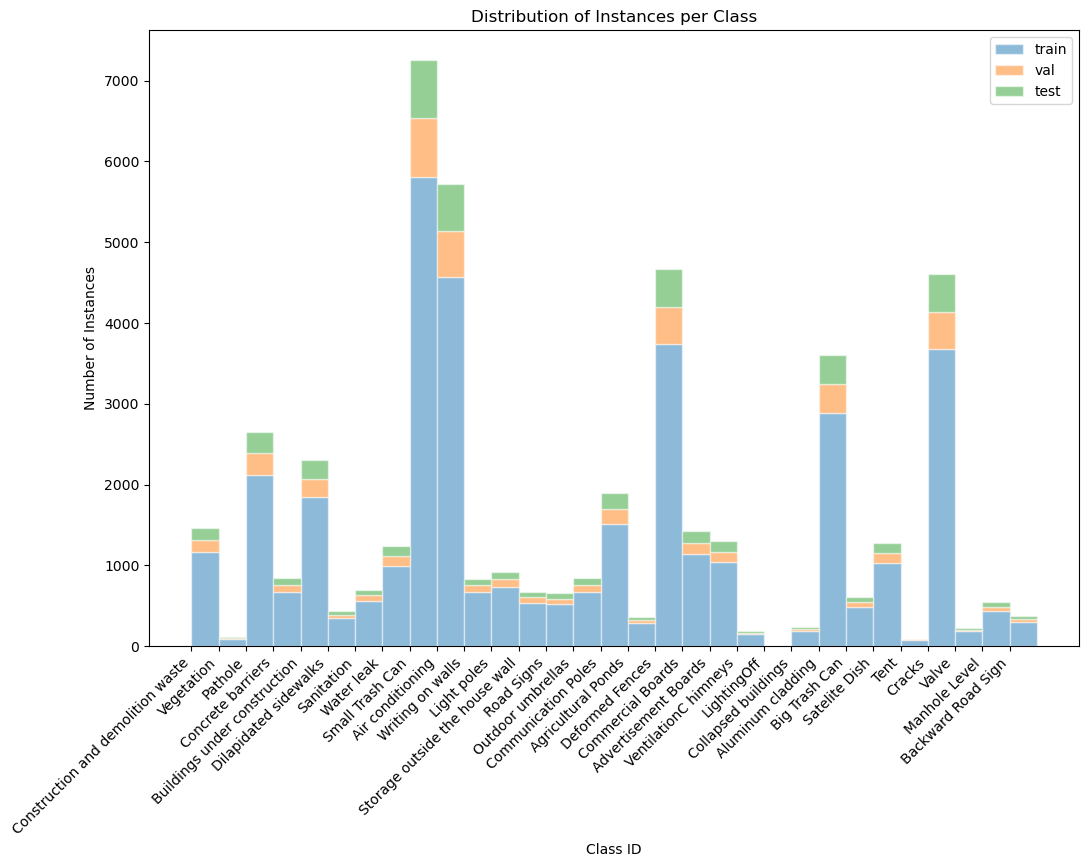

In [72]:
plot_class_distribution(class_distributions_list, class_names_dic)

# Collect All together in one function 

In [21]:
input_folder_path = 'Collected_data'
output_folder_path='full_dataset'
output_folder='data_yolo_format/dataset'
classes_list = [
    'Construction and demolition waste',
    'Vegetation',
    'Pathole',
    'Concrete barriers',
    'Buildings under construction',
    'Dilapidated sidewalks',
    'Sanitation',
    'Water leak',
    'Small Trash Can',
    'Air conditioning',
    'Writing on walls',
    'Light poles',
    'Storage outside the house wall',
    'Road Signs',
    'Outdoor umbrellas',
    'Communication Poles',
    'Agricultural Ponds',
    'Deformed Fences',
    'Commercial Boards',
    'Advertisement Boards',
    'VentilationC himneys',
    'LightingOff',
    'Collapsed buildings',
    'Aluminum cladding',
    "Big Trash Can",
    "Satelite Dish",
    "Tent",
    "Cracks",
    "Valve",
    "Manhole Level",
    "Backward Road Sign"
]

In [25]:
def main(task='det', mode='overwrite'):
    
    #0 Collect the images within their coresponding labels from a messy folder
    df = create_dataframe_and_folders(input_folder_path, output_folder_path)
    print("data shape is : ", df.shape)

    #1 Build a Dataframe that contains the metadata for each image.
    df = read_txt_from_df(df, task=task)

    #2 Function to create an output folder if it doesn't exist and filter images with missed annotations
    missed_annot_df = get_missed_annot(df, output_folder='missed_annot')

    #3 Saves images with missed annotations to a specified output folder.
    save_missed_annot(missed_annot_df, output_folder='missed_annot')

    #4 Function to drop rows with missed annotations from the original DataFrame
    drop_missed_annot(df, missed_annot_df)

    #5 Split the collected data into (images and labels) folders.
    df = copy_files_to_folders(df, output_folder_path, mode=mode)


    #6 Function to Computes aggregated metrics including 'cnt', 'avg_w', 'avg_h', and 'avg_ratio'
    processed_df = process_dataframe(df)
    aggregated_df = compute_aggregated_metrics(processed_df)

    #7 Assigns fold numbers to a DataFrame using Multilabel Stratified K-Fold cross-validation.
    aggregated_df = assign_stratifiedKFold(aggregated_df)
    
    #8 valiadte the number of images in each split
    fold_range_train = range(8)
    fold_val = 8
    fold_test = 9
    train_df, val_df, test_df = process_folds(aggregated_df, fold_range_train, fold_val, fold_test)
    
    #9 Move images to the respective folders
    move_images(train_df, split_type = 'train')
    move_images(test_df,split_type = 'test')
    move_images(val_df, split_type = 'val')

    yaml_file_path = create_yaml_file(classes_list, output_folder_path='data_yolo_format/dataset/')

In [26]:
main(task='det', mode='overwrite')

go through the input folder : 11it [00:00, 75.07it/s]
Check if either file_id or filename matches in both images_names_dict and labels_names_dict: 100%|██████████| 25330/25330 [01:00<00:00, 415.76it/s]


data shape is :  (48128, 3)


Reading label files: 100%|██████████| 48128/48128 [00:08<00:00, 5689.83it/s]


Got 0 images with missed annotations
Images with missed annotations have been copied successfully to missed_annot
0 images with missed annotations from the original DataFrame have been dropped successfully!
Images and text files copied successfully.
Train Data shape: (38503, 42)
Validation Data shape: (4812, 42)
Test Data shape: (4813, 42)
Train Percentage: 80.00%
Validation Percentage: 10.00%
Test Percentage: 10.00%
data_yolo_format/dataset/train/images
data_yolo_format/dataset/test/images
data_yolo_format/dataset/val/images
YAML file is created successfully at:  data_yolo_format/dataset/dataset.yaml
